# Project 3: BPNN
### Owen Queen, COSC 522
This notebook implements the various sections of the Project 3 writeup.

Note: Many of the models in this notebook save the output as a .npy file. This is for efficiency reasons because some of the models took a very long time to run, so it allows us to separate the training and evaluation stages.

Also note that the results seen in this notebook will not directly reflect the results in the report. This notebook's purpose is to simply provide the code that I ran to obtain my results on the report.

## Task 1
Subtasks 1 and 2 of Task 1 is not shown in this notebook. Please see the README for a description of how to find Task 1 code.

Code to run Subtask 3 can be found in the `mnist_loader.py` file. Running this script will produce the grid of randomly-sampled digits.

## Task 2
"Bayesian-based classification.Use load_data() to read in the data."

In [1]:
import time
import numpy as np
from mylearn import knn, mpp
from mnist_loader import load_data_wrapper, unvectorize_result
from acc_metrics import confusion_matrix, classwise_accs
from dim_reduce import pca
from util import accuracy_score
from network_oq import Network
from load_XOR import *

In [3]:
# Load in the data:
train, val, test = load_data_wrapper("mnist.pkl.gz")

train = list(train)
Xtrain        = np.array([np.ravel(sample[0]) for sample in train])
Ytrain_vector = np.array([np.array(sample[1]) for sample in train])
Ytrain_scalar = np.array([unvectorize_result(sample[1]) for sample in train])

val = list(val)
Xval        = np.array([np.ravel(sample[0]) for sample in val])
Yval_scalar = [sample[1] for sample in val]

test = list(test)
Xtest        = np.array([np.ravel(sample[0]) for sample in test])
Ytest_scalar = [sample[1] for sample in test]

### Part 1: KNN
"Apply kNN classifier with an appropriate k and report the performance."

The below code takes a very long time to run, so be cautioned before trying to run it.

The k value was chosen to arbitrarily be 50. A more comprehensive study of the k value will be shown in the Bonus question for this Task.

In [4]:
# Set the k value to run the model
#  Saves the values to file when done
k = 50

start_time = time.time()
predictions = knn(Tr = Xtrain, yTr = Ytrain_scalar, Te = Xtest, k = k)
print("KNN Run time:", time.time() - start_time)

np.save("task2/knn_mnist/pred_knn={}.npy".format(k), predictions)

KNN Run time: 2027.881749868393


In [6]:
k = 50
knn_pred = np.load("task2/knn_mnist/pred_knn={}.npy".format(k))
knnclasswise_a, knnoverall_a = accuracy_score(y = Ytest_scalar, y_model = knn_pred)
print("kNN (k = {}) Overall Accuracy:".format(k), knnoverall_a)

kNN (k = 50) Overall Accuracy: 0.9509


/Users/owenqueen/Desktop/COSC_522/project3/util.py:47: RuntimeWarning: invalid value encountered in long_scalars
  acc_i[i] = (np.sum(GT_i and correct_all) / np.sum(GT_i))


### Part 2: MPP
"Apply MPP (Case 1) classifier and report the performance."

In [7]:
# Run the time for the execution:
start_time = time.time()
predictions_mpp = mpp(Tr = Xtrain, yTr = Ytrain_scalar, Te = Xtest, cases = 1, P = [1/10] * 10)
print("MPP Case 1 Run Time:", time.time() - start_time)

np.save("task2/pred_mpp.npy", predictions_mpp)

MPP Case 1 Run Time: 1.2795917987823486


In [8]:
mpp_pred = np.load("task2/pred_mpp.npy")
mppclasswise_a, mppoverall_a = accuracy_score(y = Ytest_scalar, y_model = mpp_pred)
print("MPP (Case 1) Overall Accuracy:", mppoverall_a)

MPP (Case 1) Overall Accuracy: 0.82


### Part 3: Applying PCA

In the below code, we run PCA with a tolerance of 0.15. This value was chosen empirically, based off a value in a previous project.

In [9]:
Xtrain_pca, Xtest_pca, error_rate = pca(Xtrain, Xtest, tolerance = 0.15, return_both = True)
# 0.15 chosen here because we used this value in a previous project

np.save("task2/pca_mnist/train/train_tol=0.15.npy", Xtrain_pca) # Saving these as files for later use
np.save("task2/pca_mnist/test/test_tol=0.15.npy", Xtest_pca)

print("Number of eigenvectors kept:", Xtrain_pca.shape[1])
print("Error rate:", error_rate)

Number of eigenvectors kept: 59
Error rate: 0.149658633649084


In [10]:
# Loading in the PCA data
Xtrain_pca = np.load("task2/pca_mnist/train/train_tol=0.15.npy")
Xtest_pca = np.load("task2/pca_mnist/test/test_tol=0.15.npy")

#### MPP with PCA

In the code below, we run MPP Case 1 classifier on the dataset derived from PCA. I assume equal prior probabilities (1/10 for each class).

In [11]:
start_time = time.time()
predictions_mpp_pca = mpp(Tr = Xtrain_pca, yTr = Ytrain_scalar, Te = Xtest_pca, cases = 1, P = [1/10] * 10)
print("MPP Case 1 Run Time (PCA):", time.time() - start_time)

mppclasswise_a_pca, mppoverall_a_pca = accuracy_score(y = Ytest_scalar, y_model = predictions_mpp_pca)
print("MPP (Case 1) Overall Accuracy (PCA):", mppoverall_a_pca)

MPP Case 1 Run Time (PCA): 0.5272500514984131
MPP (Case 1) Overall Accuracy (PCA): 0.8188


#### kNN with PCA

In the code below we run kNN classification on the dataset derived from PCA. The k value is again chosen to be 50.

In [12]:
k = 50

start_time = time.time()
knn_pca_pred = knn(Tr = Xtrain_pca, yTr = Ytrain_scalar, Te = Xtest_pca, k = k)
print("KNN (k = {}) Run time (PCA):".format(k), time.time() - start_time)

np.save("task2/pca_mnist/knn_pca/pred_knn={}.npy".format(k), knn_pca_pred)

KNN (k = 50) Run time (PCA): 241.43638920783997


In [13]:
k = 50
knn_pca_pred = np.load("task2/pca_mnist/knn_pca/pred_knn={}.npy".format(k))
knn_pca_classwise_a, knn_pca_overall_a = accuracy_score(y = Ytest_scalar, y_model = knn_pca_pred)
print("kNN (k = {}) Overall Accuracy:".format(k), knn_pca_overall_a)

kNN (k = 50) Overall Accuracy: 0.9599


### Bonus

"Comprehensive study of k in kNN and error rate in PCA - Output two figures, overall_accuracy vs. k without PCA, overall_accuracy vs. error rate with k fixed."

The runtime for this bonus problem ended up being fairly long. Therefore, I have put the code for this in four scripts contained in the `task2` directory. The descriptions of the scripts are shown below:

1. `run_kNN.py`
    - Runs kNN on MNIST for varying k values.
2. `get-kNN-accs.py`
    - Prints the kNN accuracies saved from running `run_kNN.py`.
3. `run-PCA.py`
    - Generates datasets with PCA for differing tolerances.
4. `run-kNNvsPCA.py`
    - Runs kNN with k = 20 for each of the datasets generated in `run-PCA.py`.

## Task 3
"Connection-based classification. Study Nielsen's code,  ‘network.py’, and perform the following subtasks:"

In [2]:
# Function to run the function and load data

def train_network(epochs = 30, mbs = 10, eta = 3.0, layers = [784, 30, 10]):
    '''
    mbs = mini-batch size
    eta = learning rate
    '''
    # Get data from pickle file
    train_net, val_net, test_net = load_data_wrapper("mnist.pkl.gz", output_size = (784, 1))

    # Declare the network object
    base_net = Network(layers, activation = "sigmoid")

    st = time.time()
    # Run the stochastic gradient descent training:
    base_net.SGD(training_data = train_net, epochs = epochs, mini_batch_size = mbs, \
                eta = eta, test_data = test_net, plot = True)
    
    print("Time training:", time.time() - st)

1. Stochastic gradient descent (SGD)
Descriptions of these trials are on the report.

"Adjust the mini-batch size from 1, 10, 100, 1,000, to 10,000. Compare the time spent and accuracy at epoch = 30. Plot a bar chart or use a table to present the difference. Also attach the convergence curve for each size. From the performance differences you observed, what can you learn in terms of an appropriate size for the mini-batches?"

Accuracy at Epoch 30 = 0.91040


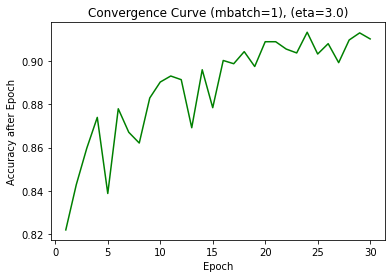

Time training: 650.6592969894409


In [3]:
train_network(epochs = 30, mbs = 1, eta = 3.0, layers = [784, 30, 10])

Accuracy at Epoch 30 = 0.95610


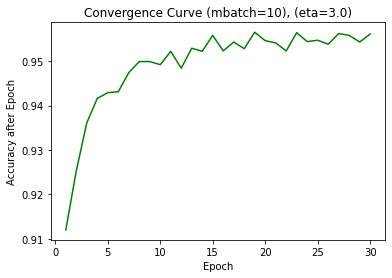

Time training: 449.7993960380554


In [4]:
train_network(epochs = 30, mbs = 10, eta = 3.0, layers = [784, 30, 10])

Accuracy at Epoch 30 = 0.93540


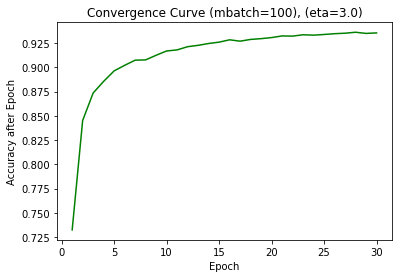

Time training: 422.9433271884918


In [5]:
train_network(epochs = 30, mbs = 100, eta = 3.0, layers = [784, 30, 10])

Accuracy at Epoch 30 = 0.87840


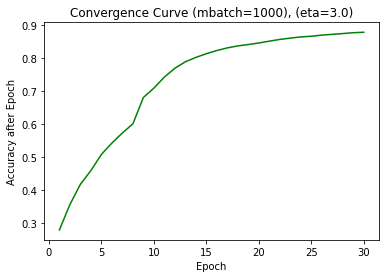

Time training: 429.87050890922546


In [6]:
train_network(epochs = 30, mbs = 1000, eta = 3.0, layers = [784, 30, 10])

Accuracy at Epoch 30 = 0.45020


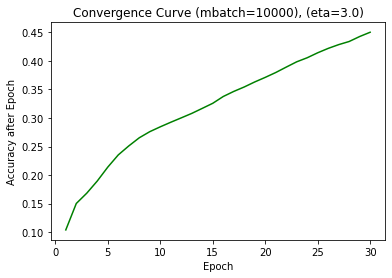

Time training: 407.55801606178284


In [8]:
train_network(epochs = 30, mbs = 10000, eta = 3.0, layers = [784, 30, 10])

2.	“On learning rate. Fix the mini-batch size at 10, adjust the learning rate to be 0.1, 1, 10, and 100. Compare the time spent and accuracy at epoch = 30. Plot a bar chart or use a table to present the difference. Also attach the convergence curve for each rate." 

Accuracy at Epoch 30 = 0.73750


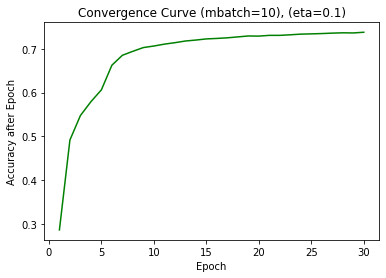

Time training: 428.0101501941681


In [9]:
train_network(epochs = 30, mbs = 10, eta = 0.1, layers = [784, 30, 10])

Accuracy at Epoch 30 = 0.94150


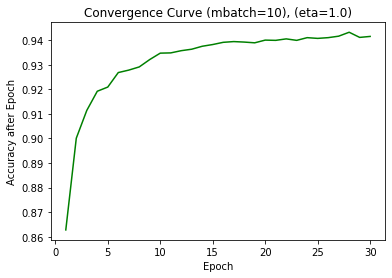

Time training: 422.4230990409851


In [10]:
train_network(epochs = 30, mbs = 10, eta = 1.0, layers = [784, 30, 10])

Accuracy at Epoch 30 = 0.93920


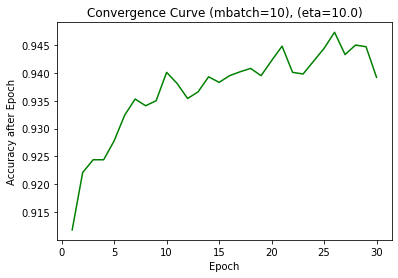

Time training: 427.08162808418274


In [11]:
train_network(epochs = 30, mbs = 10, eta = 10.0, layers = [784, 30, 10])

Accuracy at Epoch 30 = 0.12270


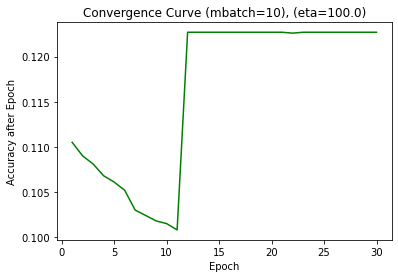

Time training: 430.94412112236023


In [12]:
train_network(epochs = 30, mbs = 10, eta = 100.0, layers = [784, 30, 10])

3. "On the number of epochs. Fix the mini-batch size at 10, and learning rate at 3.0, extend the number of epochs to 100. Show the convergence curve."

Accuracy at Epoch 100 = 0.94900


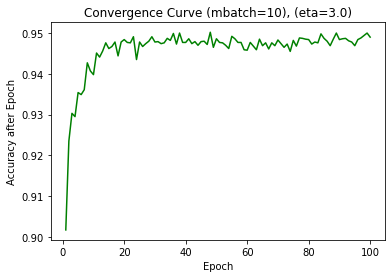

Time training: 1462.9095129966736


In [14]:
train_network(epochs = 100, mbs = 10, eta = 3.0, layers = [784, 30, 10])

4. “On the network structure. Fix the mini-batch size at 10, the learning rate at 3.0, the number of epochs at 30.”

    a. "Change the number of hidden nodes in the second layer from 10, 50, to 100. Compare the time spent and accuracy at epoch = 30. Plot a bar chart or use a table to present the difference. Also attach the convergence curve for each size."

Accuracy at Epoch 30 = 0.91470


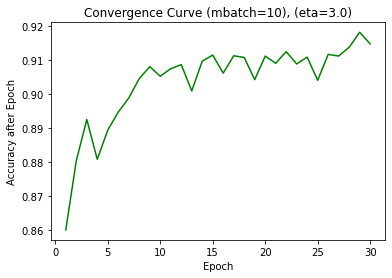

Time training: 196.3824179172516


In [13]:
train_network(epochs = 30, mbs = 10, eta = 3.0, layers = [784, 10, 10])

Accuracy at Epoch 30 = 0.86660


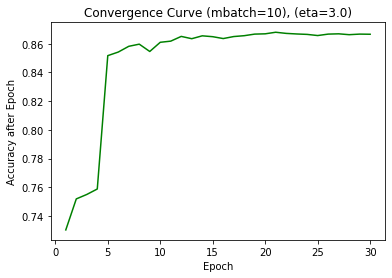

Time training: 688.7980420589447


In [15]:
train_network(epochs = 30, mbs = 10, eta = 3.0, layers = [784, 50, 10])

Accuracy at Epoch 30 = 0.96420


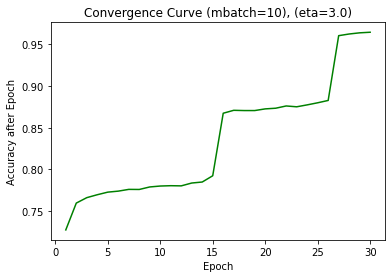

Time training: 1319.7630310058594


In [16]:
train_network(epochs = 30, mbs = 10, eta = 3.0, layers = [784, 100, 10])

b. "Change the network structure to four layers, with [784, 30, 20, 10]. Compare the time spent and accuracy at epoch = 30 with [784, 30, 10]. Plot a bar chart or use a table to present the difference. Also attach the convergence curve for each size." 

Accuracy at Epoch 30 = 0.95340


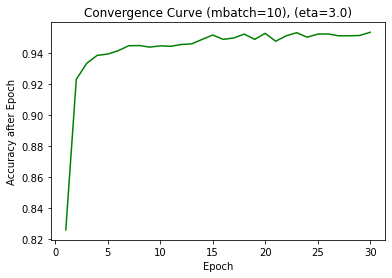

Time training: 438.81760597229004


In [17]:
train_network(epochs = 30, mbs = 10, eta = 3.0, layers = [784, 30, 10])

Accuracy at Epoch 30 = 0.95180


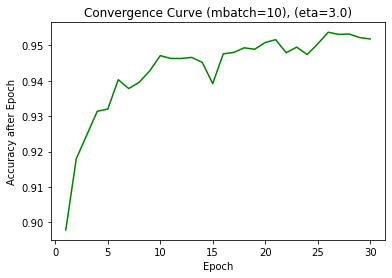

Time training: 488.0997459888458


In [3]:
train_network(epochs = 30, mbs = 10, eta = 3.0, layers = [784, 30, 20, 10])

### Bonus

1. "Replace the sigmoid function with ReLU. Self-study ReLU. Compare the performance with that of Sigmoid. Set the parameters to default."

I attempted this problem, but I was not successful. Therefore, I have not included any code here. You can see the `network_oq.py` file for the implementations of ReLU and leaky ReLU in the neural network. See the report for a more comprehensive discussion of my efforts. If you want to run these functions, follow the appropriate documentation to generate a model using them.

2. "Nielsen used a fixed number of epochs in his initial implementation of BPNN and he didn't utilize the validation set. Modify the code such that it uses the validation_data to obtain validation accuracy. If the average change in the last 5 epochs is less than, say, 0.01, then stop training. Use the weight and bias obtained then to evaluate the test set."

The code for this part is implemented in the member function named `adaptiveSGD` for the Network class in `network_oq.py`. This function modifies the SGD function to limit the number of iterations below a certain threshold.

Testing Accuracy at Epoch 8    = 0.94260
Validation Accuracy at Epoch 8 = 0.94420


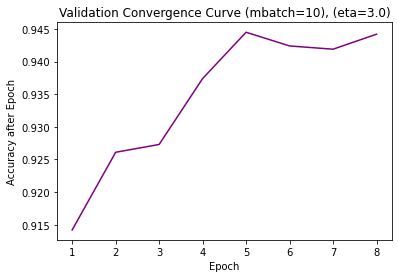

Time training: 120.79555702209473


In [4]:
# Get data from pickle file
train_net, val_net, test_net = load_data_wrapper("mnist.pkl.gz", output_size = (784, 1))

# Declare the network object
base_net = Network([784, 30, 10], activation = "sigmoid")

threshold = 0.01 # Threshold to stop the iterations at
mbs = 10         # Mini-batch size
eta = 3.0        # Learning rate

st = time.time()
# Run the stochastic gradient descent training:
base_net.adaptiveSGD(training_data = train_net, mini_batch_size = mbs, eta = eta, 
                     validation_data = val_net, test_data = test_net, plot = True)
print("Time training:", time.time() - st)

## Task 4

1. "Using only one hidden layer, plot an accuracy vs. iteration figure with 3 different numbers of hidden nodes. That is, the figure should have three convergence curves."

In [10]:
# This function will help us train the network on XOR
def train_xor(mbs = 10, eta = 3.0, layers = [2, 4, 2], max_epochs = 300):
    xor_train = make_XOR_train()
    xor_val   = make_XOR_test() # Use identical validation and test data
    xor_test  = make_XOR_test()
    
    base_net = Network(layers, activation = "sigmoid")
    
    # Runs adaptiveSGD to stop when the model converges
    st = time.time()
    eps = base_net.adaptiveSGD(training_data = xor_train, mini_batch_size = mbs,
            validation_data = xor_val, max_epochs = max_epochs, eta = eta, 
            test_data = xor_test, threshold = 0, acc_thresh = 1, plot = True)
    print("Time training:", time.time() - st)

We will run 3 different numbers of nodes for the hidden layer: 2, 4, and 8.

Testing Accuracy at Epoch 92    = 1.00000
Validation Accuracy at Epoch 92 = 1.00000


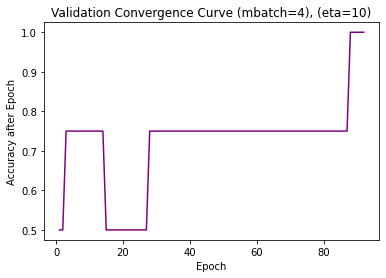

Time training: 0.13338708877563477


In [4]:
train_xor(mbs = 4, eta = 10, layers = [2, 2, 2])

Testing Accuracy at Epoch 75    = 1.00000
Validation Accuracy at Epoch 75 = 1.00000


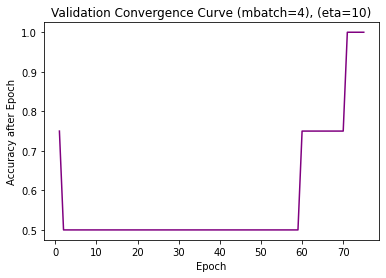

Time training: 0.13006377220153809


In [5]:
train_xor(mbs = 4, eta = 10, layers = [2, 4, 2])

Testing Accuracy at Epoch 51    = 1.00000
Validation Accuracy at Epoch 51 = 1.00000


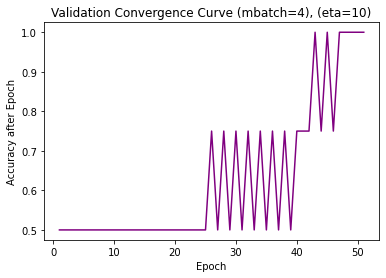

Time training: 0.1251370906829834


In [6]:
train_xor(mbs = 4, eta = 10, layers = [2, 8, 2])

2. "Using only two nodes in each layer, plot an accuracy vs. iteration figure with 3 different numbers of layers."

For this part, we will use 3 different numbers of total layers: 3, 4, and 5. Note that the maximum number of epochs allowed is 300.

Testing Accuracy at Epoch 179    = 1.00000
Validation Accuracy at Epoch 179 = 1.00000


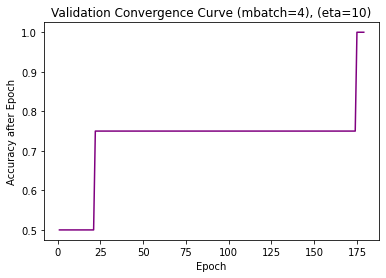

Time training: 0.16163897514343262


In [11]:
train_xor(mbs = 4, eta = 10, layers = [2, 2, 2])
# Same code as in previous part

Testing Accuracy at Epoch 211    = 1.00000
Validation Accuracy at Epoch 211 = 1.00000


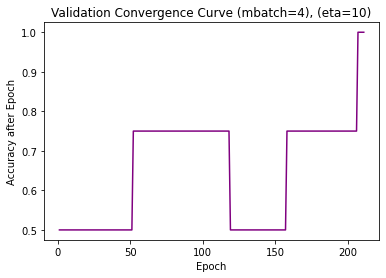

Time training: 0.18710994720458984


In [12]:
train_xor(mbs = 4, eta = 10, layers = [2, 2, 2, 2])

Testing Accuracy at Epoch 300    = 0.75000
Validation Accuracy at Epoch 300 = 0.75000


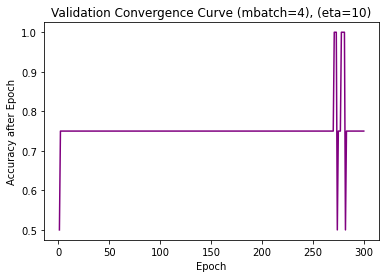

Time training: 0.275310754776001


In [13]:
train_xor(mbs = 4, eta = 10, layers = [2, 2, 2, 2, 2])